(trans_d_linregr)=

# Part III: Trans-dimensional Sampling

In this section, we utilise the trans-dimensional feature of BayesBay.

Instead of assuming the number of degrees of the polynomial function, we provide a range of 
dimension numbers for the samplers to explore. If you haven't done so, we recommend reading
[Part I: Known Data Noise](simple_linregr) before continuing this page, as formalised problem
description and detailed usage explanation won't be repeated here.

## Import libraries and define constants

In [1]:
import numpy as np
import matplotlib
import bayesbay as bb

In [2]:
# True model
M_TRUE = np.array([20, -10, -3, 1])

# Constants for dimensions
N_DIMS_MIN = 1
N_DIMS_MAX = 15

# Constants for data
N_DATA = 15
DATA_NOISE_STD = 20
DATA_X = np.linspace(-5, 10, N_DATA)

## Data predictions and kernel

In [3]:
# Forward function
def fwd(m: np.ndarray) -> np.ndarray:
    fwd_operator = np.vander(DATA_X, len(m), True)
    return fwd_operator @ m

def fwd_bayesbay(state: bb.State) -> np.ndarray:
    m = state["my_param_space"]["coefficients"]
    return fwd(m)

# Generate synthetic data
y = fwd(M_TRUE.T)
y_noisy = y + np.random.normal(0, DATA_NOISE_STD, y.shape)

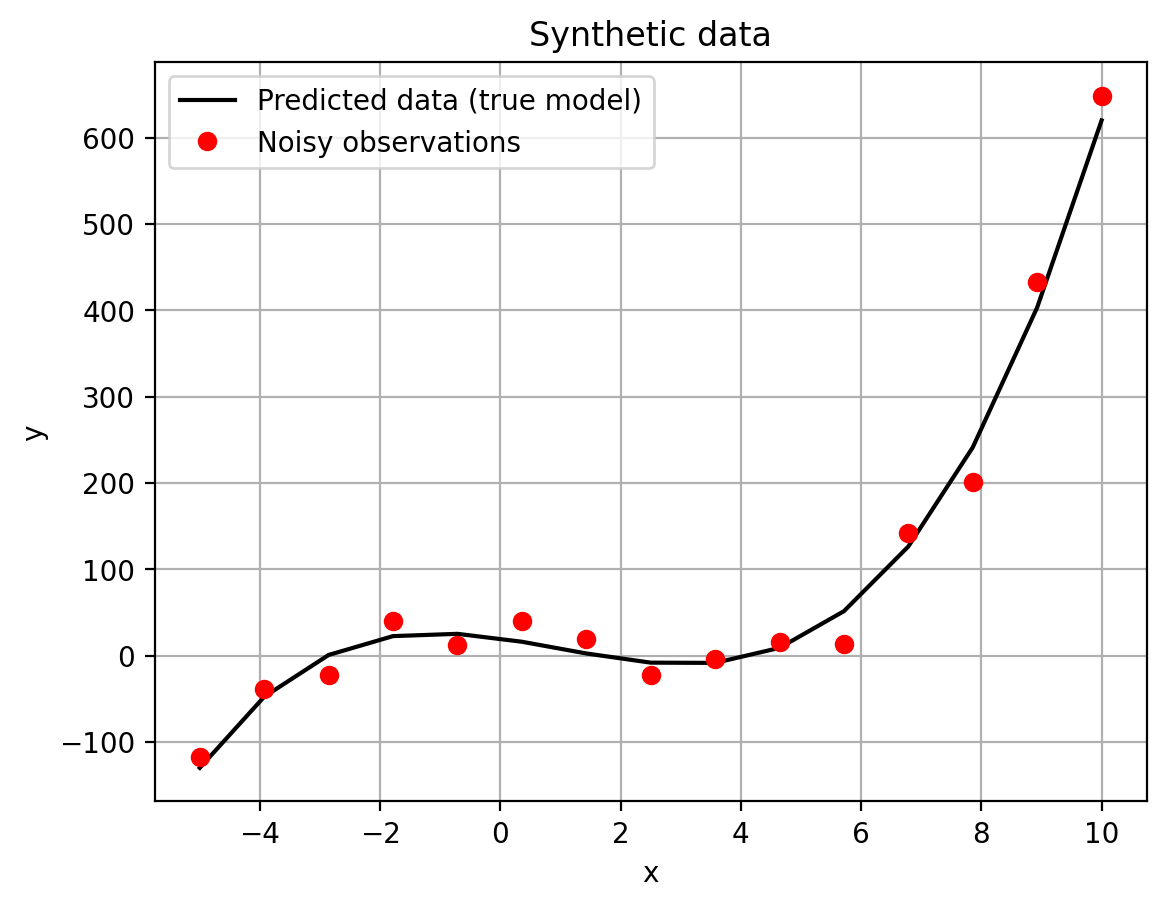

In [4]:
# Plot the data
fig, ax = matplotlib.pyplot.subplots(dpi=200)
ax.set_title('Synthetic data')
ax.plot(DATA_X, y, 'k', label='Predicted data (true model)')
ax.plot(DATA_X, y_noisy, 'ro', label='Noisy observations')
ax.grid()
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
matplotlib.pyplot.show()

## Setting up the Bayesian sampling

### **1. Prior probability**

In [5]:
# Define parameter
coefficients = bb.parameters.GaussianParameter(
    name="coefficients", 
    mean=0, 
    std=10, 
    perturb_std=1
)

### **2. Parameter space and parameterization**

In [6]:
# Define parameterization
param_space = bb.parameterization.ParameterSpace(
    name="my_param_space", 
    n_dimensions_min=N_DIMS_MIN, 
    n_dimensions_max=N_DIMS_MAX, 
    parameters=[coefficients]
)
parameterization = bb.parameterization.Parameterization(param_space)

### **3. Data misfit evaluation: the LogLikelihood**

In [7]:
# Define log likelihood
target = bb.Target(
    name="my_data", 
    dobs=y_noisy,
    covariance_mat_inv=1/DATA_NOISE_STD**2
)
log_likelihood = bb.LogLikelihood(target, fwd_bayesbay)

## Run the Bayesian sampling

In [8]:
# Run the sampling
N_ITERATIONS = 40_000
SAVE_EVERY = 100

inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    log_likelihood=log_likelihood, 
    n_chains=10, 
)
inversion.run(
    n_iterations=N_ITERATIONS, 
    save_every=SAVE_EVERY,
    print_every=N_ITERATIONS // 10, 
    verbose=False, 
)

## Retrieve the results and plot

In the following block, we retrieve the saved data predictions and number of dimensions.

We will discard the first 40% iterations from all the chains while plotting the data 
predictions and number of dimensions for the samples.

We will keep all the samples saved while plotting the change of misfit over iterations,
and the change of dimensions over iterations.

In [9]:
# Get the results
results_by_chains = inversion.get_results(concatenate_chains=False)
discard = int(0.4 * N_ITERATIONS / SAVE_EVERY)
samples_n_dims_by_chains = results_by_chains["my_param_space.n_dimensions"]
samples_d_pred_by_chains = results_by_chains["my_data.dpred"]
samples_n_dims = np.hstack([s[discard:] for s in samples_n_dims_by_chains])
samples_d_pred = np.array(samples_d_pred_by_chains)[:,discard:,:]
samples_d_pred = samples_d_pred.reshape(-1, samples_d_pred.shape[2])

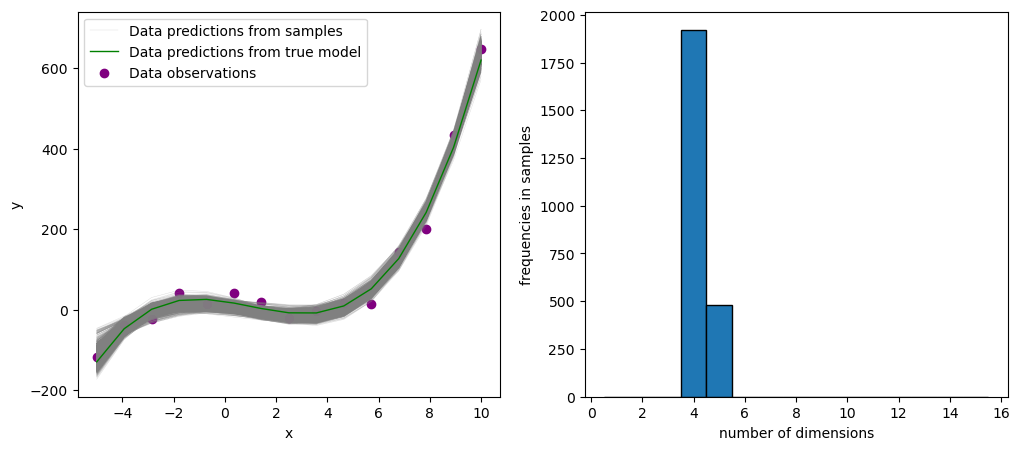

In [10]:
# Plot samples dimension histogram and samples' data predictions
fig, (ax1, ax2) = matplotlib.pyplot.subplots(1, 2, figsize=(12, 5))
bins = np.arange(N_DIMS_MIN-0.5, N_DIMS_MAX+1.5, 1)
ax2.hist(samples_n_dims, bins=bins, edgecolor='black')
ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax2.set_xlabel("number of dimensions")
ax2.set_ylabel("frequencies in samples")
ax1.plot(
    DATA_X, samples_d_pred[0], c="gray", lw=0.3, alpha=0.3, 
    label="Data predictions from samples"
)
for d_pred in samples_d_pred[1:]:
    ax1.plot(DATA_X, d_pred, c="gray", lw=0.3, alpha=0.3)
ax1.plot(DATA_X, y, c="green", lw=1, alpha=1, label="Data predictions from true model")
ax1.scatter(DATA_X, y_noisy, c="purple", label="Data observations")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend();

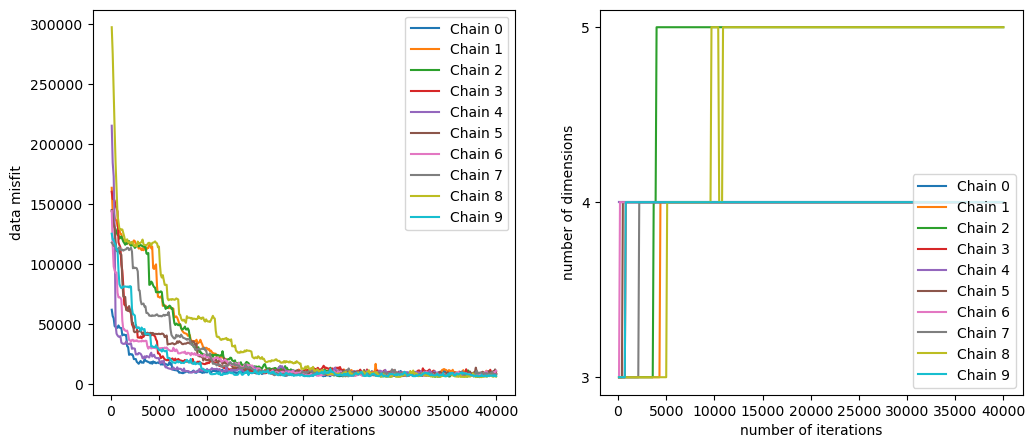

In [11]:
# Plot the changes to the misfit for each chain
fig, (ax3, ax4) = matplotlib.pyplot.subplots(1, 2, figsize=(12, 5))
iterations = range(SAVE_EVERY-1, N_ITERATIONS, SAVE_EVERY)
for i, c in enumerate(inversion.chains):
    data_misfits = []
    for d_pred in samples_d_pred_by_chains[i]:
        data_misfits.append(np.sum((d_pred - y_noisy)**2))
    ax3.plot(iterations, data_misfits, label=f"Chain {c.id}")
    ax4.plot(iterations, samples_n_dims_by_chains[i], label=f"Chain {c.id}")
ax3.set_xlabel("number of iterations")
ax3.set_ylabel("data misfit")
ax3.legend()
ax4.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax4.set_xlabel("number of iterations")
ax4.set_ylabel("number of dimensions")
ax4.legend(loc="lower right")